# Variational Autoencoders (VAE)

https://www.youtube.com/watch?v=3G5hWM6jqPk&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=5<br>
https://github.com/lyeoni/pytorch-mnist-VAE/blob/master/pytorch-mnist-VAE.ipynb

The **MNIST dataset** consists of 60,000 images of hand written digit, where each image has size 28X28.

We will define and train **variational autoencoders (VAEs)** composed of linear and convolutional layers on the MNIST noisy dataset:

<img src="files/figures/mnist.png" width="600px"/>

## 0. Libraries

In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np

import matplotlib.pyplot as plt

In [5]:
torch.cuda.is_available()

False

## 1. Load data

- The following code loads the MNIST data.
- Note that we don't need any validation set, since we are in an unsupervised setting.

In [6]:
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True,
                            download=True,
                            transform=transform)

In [7]:
# dataloader
train_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

In [10]:
# data format
data_iter = iter(train_loader)
images, labels = next(data_iter)
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [9]:
torch.min(images), torch.max(images)

(tensor(0.), tensor(1.))

## 2. Classical AE with linear layers and latent dimension 10

In order to motivate the notion of **variational autoencoder (VAE)**, we train a classical autoencoder (AE) with a latent space of (larger) dimension 10, and show that the disribution of the latent space and the the generating capabilities of the model are affected.

- Use the **encoder** of the AE to obtain the encodings in the **latent space** of 100 image samples.

- Compute the min and max bounds $[x_{min}, x_{min}]$ and $[y_{min}, y_{max}]$ of these latent points, and then sample 100 uniformly from the latent space according to the **uniform distribution** $\mathcal{U}([x_{min}, x_{min}], [y_{min}, y_{max}])$.

- Use the **decoder** of the AE to decode these latent samples into images, and plot these images. Note that the images are not well formed.

- Plot the distribution of the latent points, dim by dim, to see the latent space is not evenly distributed.

### Model

In [9]:
class Autoencoder(nn.Module):
    """Implements an linear automencoder"""

    def __init__(self, latent_dim=2):
        """constructor"""

        super().__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, self.latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid() # outputs in [0, 1]
        )

    def forward(self, x):
        """forward pass"""
        
        encoded_data = self.encoder(x)
        decoded_data = self.decoder(encoded_data)

        return decoded_data

In [10]:
model = Autoencoder(latent_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=1e-3, 
                             weight_decay=1e-5)

### Training

In [11]:
def training(model, num_epochs=24):
    """training loop"""

    num_epochs = 24
    outputs_l = []

    for epoch in range(num_epochs):

        train_loss = []

        for (inputs, _) in train_loader:

            inputs = inputs.reshape(-1, 28*28) # reshape data 28 x 28 -> 784
            outputs = model(inputs)

            loss = criterion(outputs, inputs)
            train_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = torch.mean(torch.tensor(train_loss)).item()

        print(f'Epoch:{epoch+1} \t Train loss: {train_loss:.4f}')

        outputs_l.append((epoch, inputs, outputs, train_loss))
        
    return outputs_l

In [12]:
outputs_l = training(model)

Epoch:1 	 Train loss: 0.0597
Epoch:2 	 Train loss: 0.0416
Epoch:3 	 Train loss: 0.0344
Epoch:4 	 Train loss: 0.0314
Epoch:5 	 Train loss: 0.0295
Epoch:6 	 Train loss: 0.0280
Epoch:7 	 Train loss: 0.0264
Epoch:8 	 Train loss: 0.0251
Epoch:9 	 Train loss: 0.0243
Epoch:10 	 Train loss: 0.0237
Epoch:11 	 Train loss: 0.0233
Epoch:12 	 Train loss: 0.0230
Epoch:13 	 Train loss: 0.0227
Epoch:14 	 Train loss: 0.0225
Epoch:15 	 Train loss: 0.0222
Epoch:16 	 Train loss: 0.0220
Epoch:17 	 Train loss: 0.0218
Epoch:18 	 Train loss: 0.0215
Epoch:19 	 Train loss: 0.0212
Epoch:20 	 Train loss: 0.0209
Epoch:21 	 Train loss: 0.0207
Epoch:22 	 Train loss: 0.0205
Epoch:23 	 Train loss: 0.0203
Epoch:24 	 Train loss: 0.0201


### Results

In [111]:
def plot_training_loss(outputs_l, y_label = "MSE loss", filename=""):
    "plot the training loss"
    
    plt.figure(figsize=(5, 3))

    epochs = [x[0] for x in outputs_l]
    train_loss = [x[3] for x in outputs_l]

    plt.plot(epochs, train_loss, label="training loss")
    plt.xlabel("epochs")
    plt.ylabel(y_label)
    plt.legend()
    plt.savefig(filename, format="pdf", bbox_inches="tight")
    #plt.show()

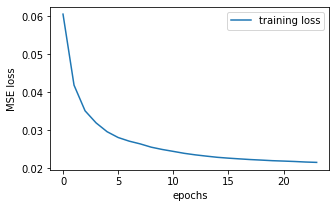

In [28]:
plot_training_loss(outputs_l, filename="figures/AE_linear_loss_2.pdf")

In [32]:
def plot_training_samples(outputs_l, filename="", num_epochs=24):
    "plot inputs and reconstructed inputs during training"

    fig, axs = plt.subplots(6, 10, 
                            figsize=(10, 7), 
                            layout="constrained",
                            gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

    for i, k in enumerate([0, num_epochs//2, num_epochs-1]):

        inputs = outputs_l[k][1].detach().numpy()
        outputs = outputs_l[k][2].detach().numpy()

        axs[2*i, 0].set_title(f"Epoch {k+1}")
        axs[2*i, 0].set_ylabel("Inputs")

        for j, item in enumerate(inputs):

            if j >= 10: break
            item = item.reshape(-1, 28,28) # for Autoencoder_Linear
            axs[2*i, j].imshow(item[0])
            axs[2*i, j].set_xticks([])
            axs[2*i, j].set_yticks([])

        axs[2*i + 1, 0].set_ylabel("Outputs")
        for j, item in enumerate(outputs):

            if j >= 10: break
            item = item.reshape(-1, 28,28) # for Autoencoder_Linear
            axs[2*i + 1, j].imshow(item[0])
            axs[2*i + 1, j].set_xticks([])
            axs[2*i + 1, j].set_yticks([])

    fig.savefig(filename, format="pdf", bbox_inches="tight")
    #plt.show()

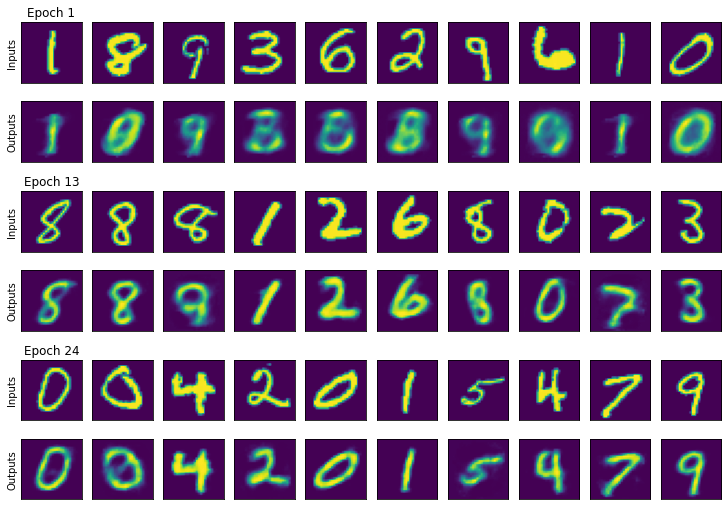

In [33]:
plot_training_samples(outputs_l, filename="figures/AE_linear_2.pdf")

### Generative capabilities of the decoder

In [34]:
# torch.save(model.state_dict(), "data/AE_linear_2.pt")

In [15]:
# model = Autoencoder()
# model.load_state_dict(torch.load("data/AE_linear_2.pt"))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [16]:
encoder = model.encoder.eval()
decoder = model.decoder.eval()
decoder

Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=784, bias=True)
  (7): Sigmoid()
)

In [37]:
# Get 100 data
inputs = [train_set[i][0] for i in range(100)]
inputs = torch.cat(inputs).reshape(-1, 28*28)
inputs.shape

torch.Size([100, 784])

In [38]:
# Encode the data
with torch.no_grad():
    inputs_encoded = encoder(inputs)
inputs_encoded.shape

torch.Size([100, 10])

In [39]:
# Get bounds of encoded data
x_bl = torch.min(inputs_encoded, axis=0)[0]
x_ur = torch.max(inputs_encoded, axis=0)[0]
x_bl, x_ur

(tensor([ 10.6823,  -0.5707,   7.7380, -11.5622, -17.0767, -28.5565, -10.7084,
         -22.4056, -17.3690, -10.3763]),
 tensor([41.7569, 14.5714, 44.6253,  8.7258,  6.7670,  6.2194,  8.2921,  2.7685,
          3.4501,  7.6717]))

In [40]:
# Uniform sampling from the latent space
samples_uniform = np.random.uniform(low=x_bl, high=x_ur, size=(100,10))
samples_uniform = torch.tensor(samples_uniform).float()

In [42]:
# Decode samples
with torch.no_grad():
    generated_samples = decoder(samples_uniform).reshape(-1, 28, 28)
    
generated_samples.shape

torch.Size([100, 28, 28])

In [294]:
# Visualize the generated data
def plot_generated_samples(generated_samples, filename=""):
    "plot generated samples"
    
    fig, axs = plt.subplots(10, 10, 
                            figsize=(10, 10), 
                            layout="constrained",
                            gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

    for i in range(10):

        samples = generated_samples[10*i:10*i+10, :, :]

        for j in range(10):

            axs[i, j].imshow(samples[j, :, :])
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])


    fig.savefig(filename, format="pdf", bbox_inches="tight")
    # plt.show()

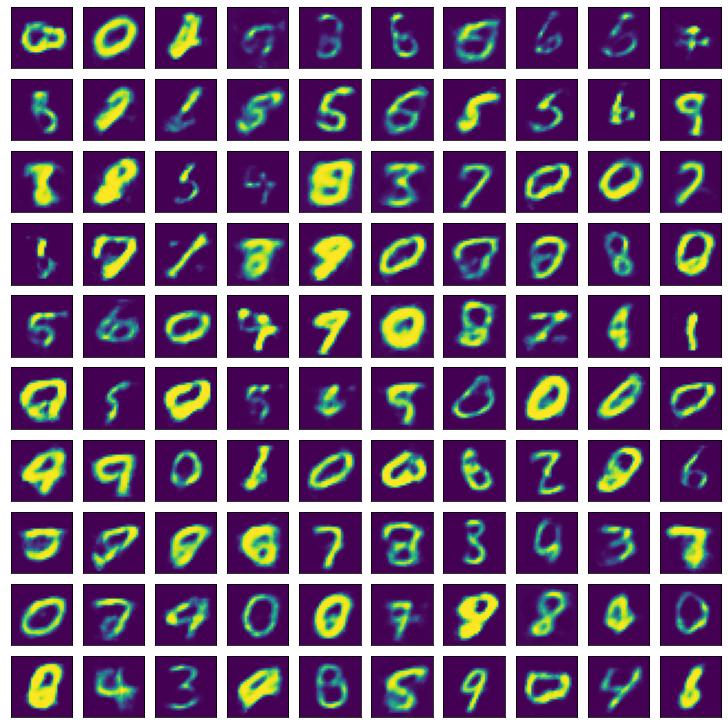

In [44]:
plot_generated_samples(generated_samples, filename="figures/AE_generator_2.pdf")

### Distribution of the latent space

In [17]:
# Plot the distribution, dim by dim, of the latent samples

def plot_latent_distribution(filename=""):
    "Generated 1024 points in the latent space and plot their distribution, dim by dim."

    # Create 1024 latent points
    latent_points = []

    with torch.no_grad():
        for batch, _ in train_loader:
            batch = batch.reshape(-1, 28*28)
            latent_points.append(encoder(batch))
            if len(latent_points) > 1000//64: break

    latent_points = torch.cat(latent_points)

    # plotting
    fig, axs = plt.subplots(2, 5, 
                            figsize=(10, 4), 
                            layout="constrained",
                            gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

    for i in range(5):

            samples_1 = np.array(latent_points[:, i])
            samples_2 = np.array(latent_points[:, i+5])
            axs[0, i].hist(samples_1, density=True, bins=15)
            axs[0, i].set_title(f"dim {i+1}")
            axs[1, i].hist(samples_2, density=True, bins=15)
            axs[1, i].set_title(f"dim {i+5+1}")


    fig.savefig(filename, format="pdf", bbox_inches="tight")
    # plt.show()

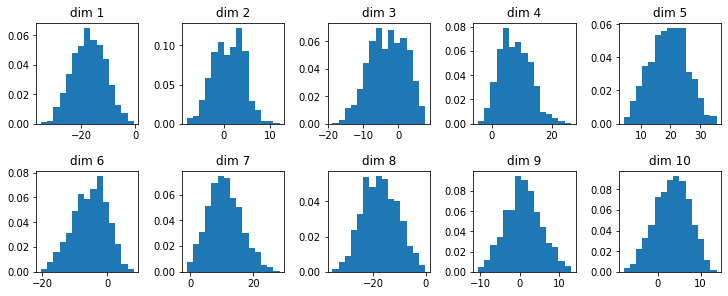

In [18]:
plot_latent_distribution(filename="figures/AE_latent_distribution.pdf")

**Conclusions**

- With a latent space of higher dimension, the generation process is really altered.

- The distribution of data in the latent space is awkward (not centered, skewed,...)

## 3. VAE with latent space of dim 2

We implement the **variational automnecoder (VAE)** with a latent space of dimensions 2, and show that the *latent space distribution* and the *generative capabilities* of the model are improved.

### Model

The following class implements a **variational autoencoder (VAE)** composed of **linear layers**.

- Understand the architecture and the loss function of this **variational autonecoder (VAE)**.

In [369]:
# model
class VariationalAutoencoder(nn.Module):
    """Implements an linear automencoder"""

    def __init__(self, latent_dim=2):
        """constructor"""

        super().__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            #nn.ReLU(),                # removed...
            #nn.Linear(32, latent_dim)
        )
        
        self.z_mean = torch.nn.Linear(32, self.latent_dim)
        self.z_log_var = torch.nn.Linear(32, self.latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()             # output neurons between 0 and 1
        )

    def sampling(self, mean, log_var):
        "sampling from the latent space"

        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mean)

        return z
    
    
    def forward(self, x):
        """forward pass"""
        
        x = self.encoder(x)
        mu, log_sigma2 = self.z_mean(x), self.z_log_var(x)
        z = self.sampling(mu, log_sigma2)
        x = self.decoder(z)

        return x, mu, log_sigma2

In [371]:
# losses not normalized hence 
alpha, beta = 10., 0.001

def loss_function(recon_x, x, mu, log_var):
    "MSE/BCE + KL loss"
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    MSE = torch.norm( (recon_x - x.view(-1, 28*28)) ) / x.shape[0]
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return alpha*MSE + beta*KLD

### Training

- Intanciate a **VAE** and an **optimizer (`torch.optim.Adam`)** with learning rate `lr=1e-3`.

- Implement a **training loop** for this model during $24$ epochs. During training, after each epoch, store the current `epoch`, `inputs`, `outputs` and `train_loss` of the model (in this order) in a list called `outputs_l`.

### Results

- Plot the training loss to confirm that the model has been trained (use the function `plot_training_loss`).

- Plot the inputs and their reconstructions by the VAE at epochs $1$, $12$ and $24$. The reconstructions should improve as the epochs increase. (use the function `plot_training_samples`).

### Visualizing the latent space

- Run the following code do which plots 1024 encoded images in the **2D latent space**.

- Note that the latent space is **normally distributed** and that the samples of different classes are **clusterized** in this space.

In [428]:
def visualize_2d_latent_space(model, filename):
    
    model.eval()
    #encoder = model.encoder.eval()

    nb_batches = 16
    data_d = {"images" : [], "labels" : []}

    for i, batch in enumerate(train_loader):

        with torch.no_grad():

            images, labels = batch[0], batch[1]
            images = images.reshape(-1, 28*28)
            
            # encode inputs and sample in the latent space
            x, mu, log_sigma2 = model(images)
            #x = encoder(images)
            #mu, log_sigma2 = model.z_mean(x), model.z_log_var(x)
            latent_points = model.sampling(mu, log_sigma2)

            if i == nb_batches:
                break
            else:
                data_d["images"].extend(latent_points)
                data_d["labels"].extend(labels)
    
    nb_images = len(data_d["images"])
    nb_labels = len(data_d["labels"])

    print(f"Nb of encoded images: {nb_images}")
    print(f"Nb of labels: {nb_labels}")

    latent_images = torch.cat(data_d["images"], axis=0).reshape(-1, 2)
    labels = torch.tensor(data_d["labels"])

    x = latent_images[:, 0]
    y = latent_images[:, 1]
    
    print(x.shape, y.shape)
    
    plt.figure(figsize=(10, 7))
    plt.title("Latent space", size=14)

    cm = plt.cm.get_cmap('rainbow', 10)

    plt.scatter(x, y, c=labels, alpha=0.6, cmap=cm)

    cbar = plt.colorbar()
    cbar.set_ticks(np.linspace(0.4, 8.6, 10))
    cbar.set_ticklabels(list(range(0, 10)))

    plt.savefig(filename, format="pdf", bbox_inches="tight")
    # plt.show()

Nb of encoded images: 1024
Nb of labels: 1024
torch.Size([1024]) torch.Size([1024])


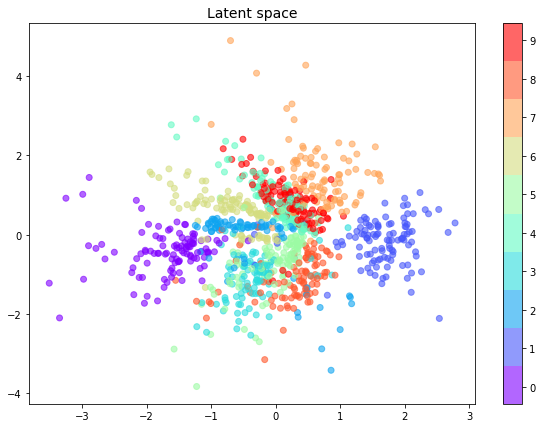

In [429]:
visualize_2d_latent_space(modelVAEd2, "figures/VAE_linear_d2_latent_space_101_MSEKL.pdf")

### Generative capabilities of the decoder

- Sample 100 points from the 2D normal distribution of mean $\mathbf{0}$ and covariance $\mathbf{I}$ (use `np.random.multivariate_normal`).

- Decode this points into images by using the *decoder** part of the VAE.

- Plot these decoded images (use `plot_generated_samples`). How do these images look? What do you think about the generative capabilities of the VAE?

## 4. VAE with latent space of dim 10

- Consider now a **variational auttoencoder (VAE)** with latent space of dim 10 (in the instanciation of your object `VariationalAutoencoder`, set `latent_dim=10`).

- Instanciate, train, visualize the inputs/outputs as the training epochs increase, and generate images according to this VAE (you can reuse you previous code on your new VAE).

- How are the generative capabilities of the VAE?

### Model

### Training

### Latent space distribution 

### Generative capabilities of the decoder

**Conclusion**

For a latent space of dimension 10, the latent space is rather normally distributed and the generation capabilities of the model are increased.